<a href="https://colab.research.google.com/github/AuraFrizzati/GoogleCloud-Terraform-EDX-course/blob/main/03_Writing_Infrastructure_Code_for_Google_Cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[03] Writing Infrastructure Code for Google Cloud**

**Objectives**

In this module, you will explore more about resources, variables, and output resources.

We will begin by exploring how to create infrastructure components using **resources** and then explore how Terraform handles **dependencies** within resources.

While we have been covering resource creation by using hard-code resource arguments, we will explore how you can **parameterize** a given **configuration** using **variables**. We will explore the syntax to declare, define and use them within your configuration.

We will then discuss how you can **export resource attributes outside the resource declaration** using **output values**.

We will then wrap up the module by discovering how you can **simplify code authoring** using **Terraform registry**, and **Cloud Foundation Toolkit**.

Upon completing this module you will be able to

- **Declare the resources** within Terraform.
- Explain **implicit** and **explicit resource dependencies**.
- Use **variables** and **output values** within the root configuration.
- Explain **Terraform Registry** and **Cloud Foundation Toolkit**.



This module focusses on the first phase of the Terraform workflow, the **Author phase**. During this phase you write your Terraform code in the HCL language.

## **3.1: Introduction to Resources**

**What are Resources?**

- Resources are **infrastructure elements**, such as: compute engine instances, VPC (Virtual Private Cloud), Cloud Storage bucket and Firewall rules. These elements can be **configured** using **Terraform code**.
- Terraform uses the **underlying APIs** of each Google Cloud service to deploy your resources

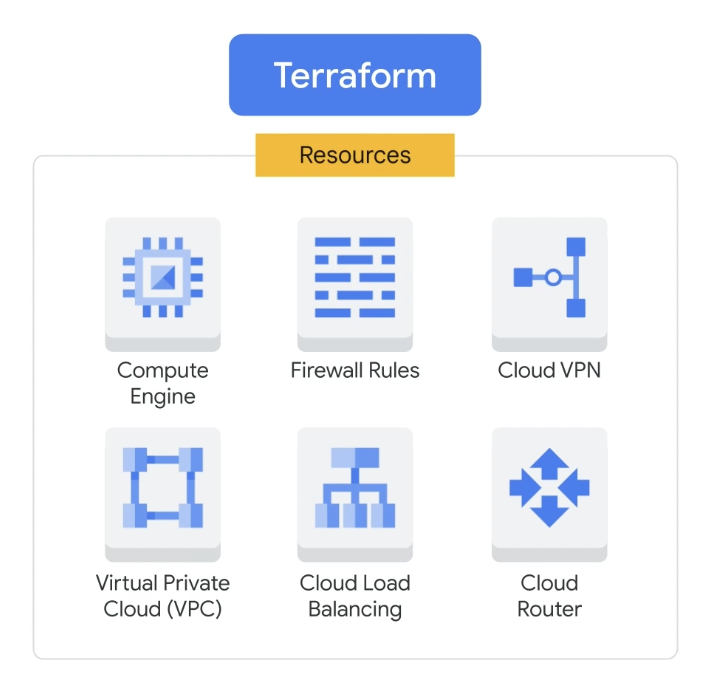

**Syntax to declare a resource**

- Resources are defined within a `.tf` file
- It is recommended that you place similar types of resources in a directory and define the resources in the `main.tf` file

```
-- network/
  -- main.tf
  -- outputs.tf
  -- variables.tf
```

```
resource "resource_type" "resource_name" {
  # Resource arguments
}
```

- The **resource block** is used to declare a **single infrastructure object**
- The `resource_type` identifies the **type of resource** being created and **depends on the provider being declared** within a Terraform module
- A **provider** is a **plugin that provides a collection of resource types**. Generally a provider is a **cloud infrastructure platform** (e.g. Google Cloud)
- **Resource arguments** are expressions to declare resources' **attributes**. Not all resource arguments must be defined, although some are instead mandatory for resource creation. Attributes can be used to define any **advanced feature** associated with a resource

**A configuration file can include multiple resources**

- You can include **multiple resources** of the same or different types in the **same Terraform configuration file**.

- These resources can even span across **multiple providers**


```
resource "google_compute_network" "vpc_network" {
  name                    = vpc-network" # Required argument
  project                 = "<Project_ID>"
  auto_create_subnetworks = false
  mtu                     = 1460
}

resource "google_compute_subnetwork" "subnetwork-ipv6" {
name                      = "ipv6-test-subnetwork" # Required argument
ip_cidr_range             = "10.0.0.0/22" # Required argument
network                   = google_compute_network.vpc_network.id # Required argument
region                    = "us-west2"

}
```

- A **resource** is identified by the `resource` keyword, followed by the **resource type**
- The resource arguments depend on the resource type.

- To **access a resource's attribute from another resource block**, use **`<resource_type>.<resource_name>.<attribute>`**
  - In the above example, the `vpc_network.id` is a computed resource attribute of a `google_compute_network` block. The `id` attribute is generated when the `vpc_network` resource is created.
  - This method can only be used when **resources** are **defined within the same root configuration**.

**Considerations for defining a resource block**

- The **resource name** of a **given resource type** must be **unique within the module**. A resource with the same name cannot exists within the same configuration:

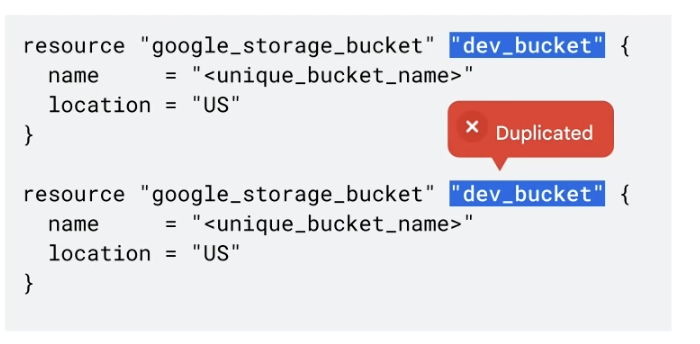

- The **resource type** is not user-defined and is a keyword **based on the provider**:

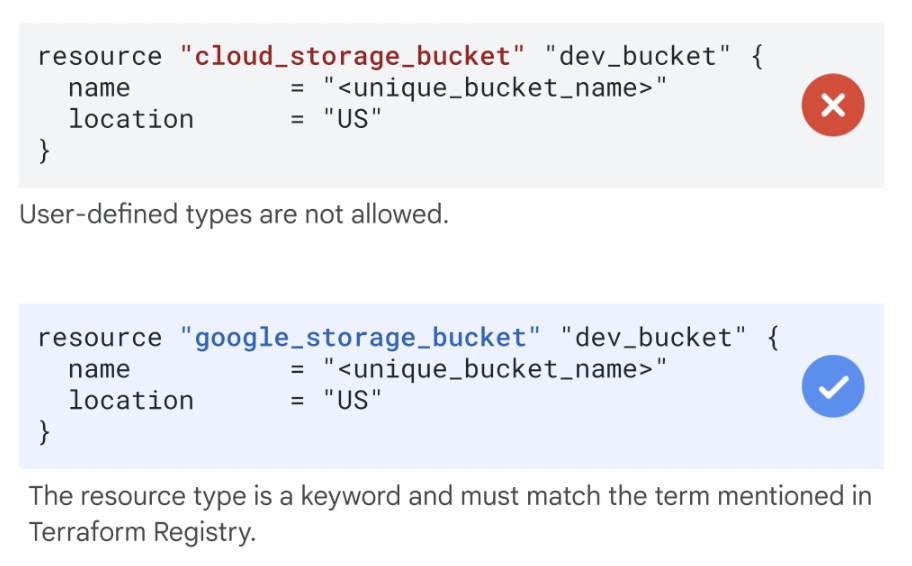

- All **configuration arguments** must be enclosed **within the resource block body** (i.e. within the curly brackets):


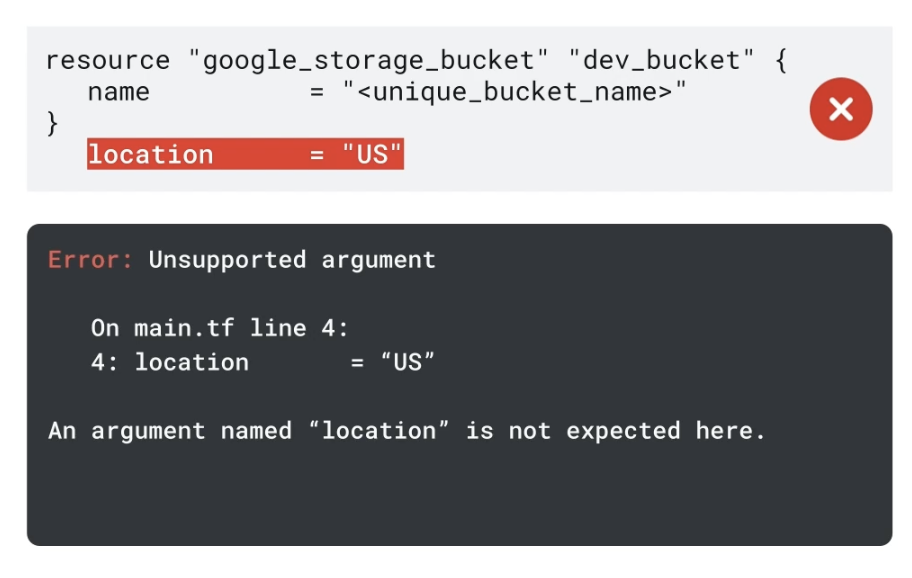

- All **required resource arguments** must be **defined**:


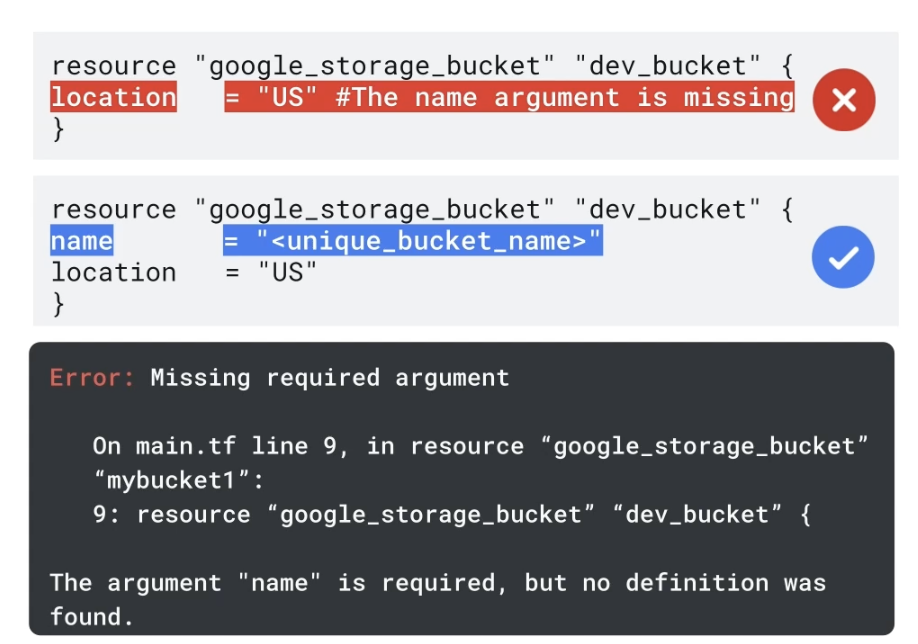

## **3.2: Meta-arguments for resources**
- The Terraform language defines many **meta-arguments**, which can be used with any resource type to **change the behaviour of the resources**

`count`: create **multiple instances** according to the value assigned to the count

`for_each`: create **multiple resource instances** as per **set of strings** (or a **map**)

`depends_on`: specify **explicit dependency**

`lifecycle`: **define the lifecycle of a resource**. This argument can be used to **prevent the destruction of a resource** for **compliance purposes** and creates a resource before destroying the replaced resource. This approach is often used for high availability.

`provider`: it selects a **non-default provider configuration**. You can have **multiple configurations for a provider**, including a default one.

### **`count`: Multiple resources of the same type**



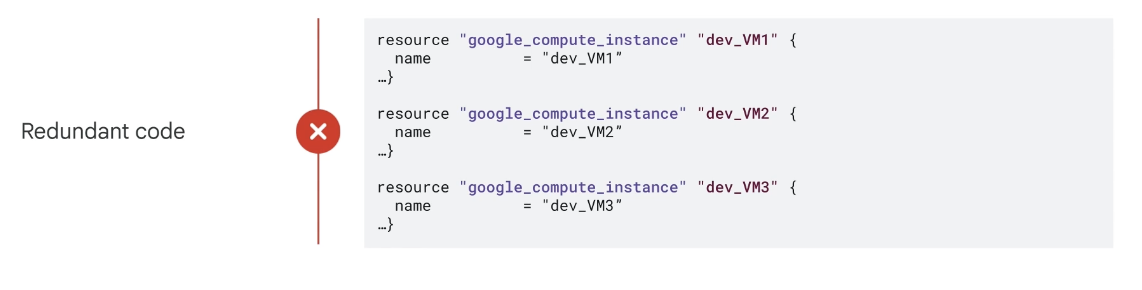

Avoid redundant code and instead create three instances of the same type with names:

```
resource "google_compute_instance" "Dev_VM" {
  count = 3
  name  = "dev_VM${count.index + 1}" # the count.index starts from 0

  # Other required arguments
}
```

### **`for_each`: Multiple resources of the same type with distinct values**

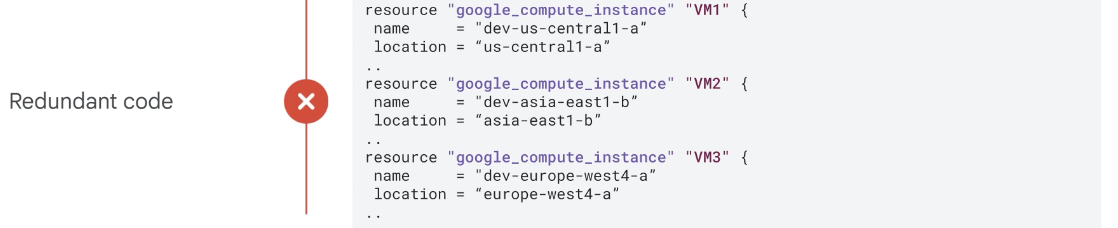

You can instead create three instances with names: `dev-*`"

```
resource "google_compute_instance" "Dev_VM"{
  for_each = toset( ["us-central1-a", "asia-east1-b", "europe-west4-a"] ) # setting a set of strings (or a map)
  name     = "dev-${each.value}"

  zone     = each.value
  # Other required arguments
}

```

## **3.3: Resource Dependencies**


### **Dependency graph**

- While building an infrastructure, you may prefer to have a **visual representation** of how your **infrastructure** is **connected** and **interdependent**

- A **dependency graph** helps you to understand your infrastructure before deploying it

- Terraform builds a dependency graph from your configurations to regenerate plans and refresh states

- The **attributes** are **interpolated** during **runtime** and **primitives** (e.g. variables, output values and providers) are **connected** in a **dependency tree**

- Terraform creates a dependency graph to determine the **correct order of operations**

- In more complex cases, with multiple resources, Terraform will perform **operations in parallel** when it is safe to do so

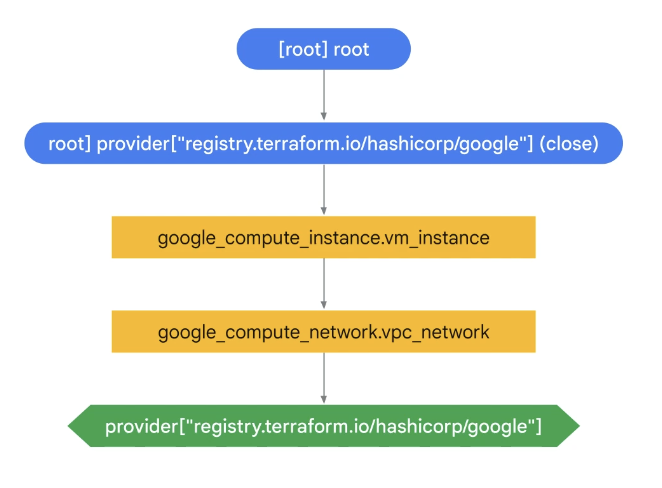

`terraform graph | dot -Tpng > graph.png`

https://developer.hashicorp.com/terraform/internals/graph

### **Resource Dependencies**

Terraform can handle **two kinds of dependencies**:

- **Implicit dependency**: dependencies known to Terraform are **detected automatically** (e.g., you cannot create a compute instance until the network is created; you cannot assign a static IP address for a compute engine instance until a static IP is reserved)

- **Explicit dependency**: dependencies unknown to Terraform must be **configured explicitely** (for example when you want to ensure a given resource is created only upon the creation of another resource)

#### **Implicit resource dependencies are handled automatically**

```
resource "google_compute_instance" "my_instance" {
  // All mandatory arguments

  network_interface {
    // implicit dependency
    network = google_compute_network.my_network.name
    access config{
    }
  }
}

resource "google_compute_network" "my_network" {
  name = "my_network_name"
}
```

- In Google Clooud, you **cannot create a compute instance without a network**. Terraform is informed of these relationships by **interpolation expressions** (which should be used whenever possible)
- The **reference** to `my_network` in the **network argument** of the `google_compute_instance` block creates an **implicit** (**known**) **dependency** on the network specified in the block `google_compute_network.my_network`

- You can **view implicit (known) dependencies** via `terrafom apply` (and also generically the **order** in which **resources** are **created**):

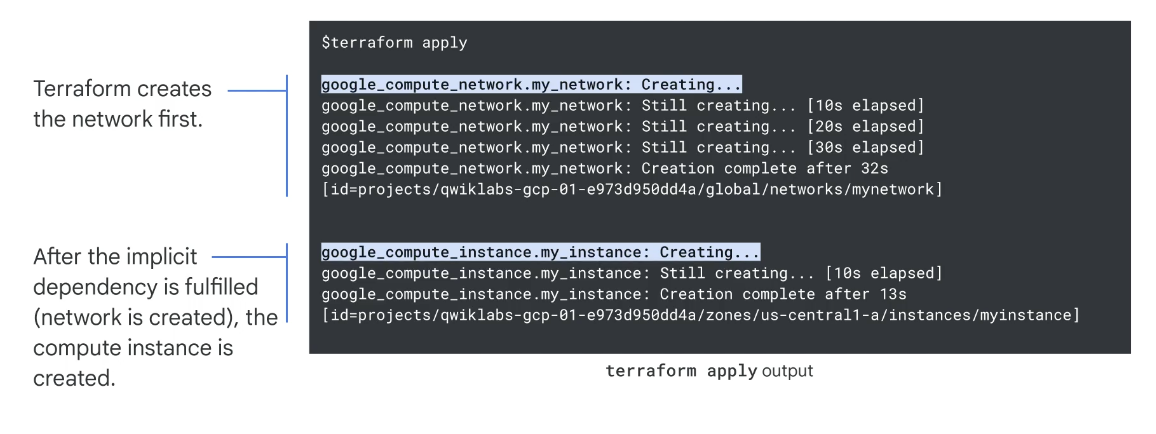

#### **Explicit (unknown) dependencies are defined by using the `depends_on` argument**

```
resource "resource_type" "resource_name" {
  ..
  depends_on = [<resource_type>.<resource_name>] # meta-argument for explicit dependency
}
```

For example, the client VM can only be created when the server VM is created:

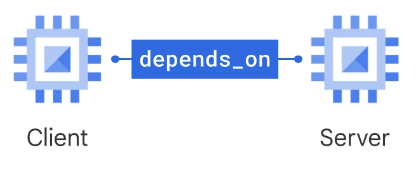

```
resource "google_compute_instance" "client" {
  ..
  depends_on = [google_compute_instance.server] # meta-argument for explicit dependency
}

resource "google_compute_instance" "server" {
  # All required configuration options
}

```

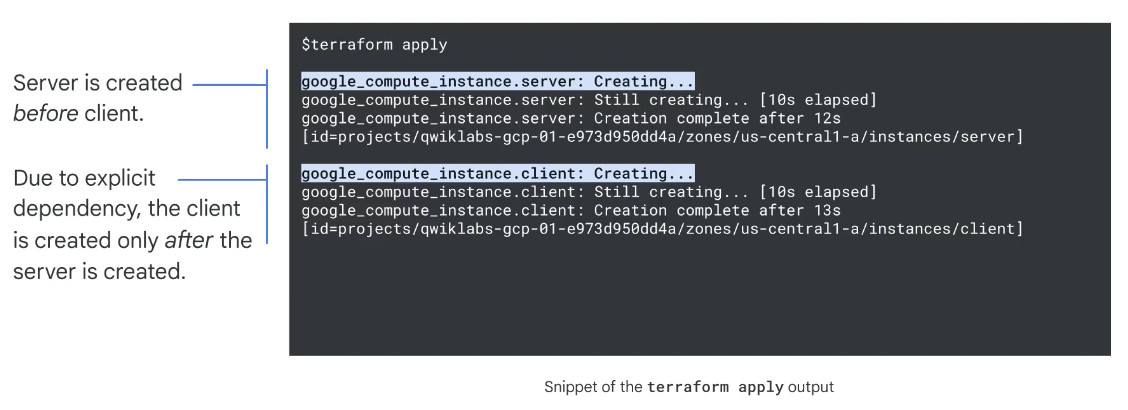

**The order in which resources are defined in your Terraform configuration files has no effect on the order in which Terraform applies your changes**. So you can organise your configuration files in the way that makes the most sense to you

## **3.4: Variables**

- You can **parameterise** your **configuration** and **define argument values during** the `apply` phase of the Terraform workflow (rather than hard-coding them)

- This enables you to **standardise your code** while maintaining the **flexibility to customise resource attributes at runtime**

### **Variables overview**

- **Variables parameterise your configuration** without altering the source code. They allow to parameterise values **shared between resources**

- **Input variables** serve as parameters to Terraform, allowing for easy customisation. They allow to **separate source code** from **value assignments**.

- Variables allow you to assign a value to the resource attribute at runtime.

- After a variable has been defined, there are **different ways** to **set** its **value** at **runtime** (including **environment variables**, **CLI options** and **key-value files**)

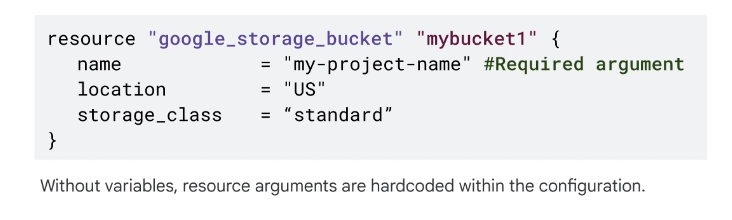

We recommend that you **save all variables' declarations in a separate file** named `variables.tf`


```
-- server/
  -- main.tf
  -- outputs.tf
  -- variables.tf
```

- **Variables** must be **declared** in the **`variable` block**
- There are 2 **rules** for **naming variables**:
  - The **name** of the variable must be **unique within a module**
  - Variable names cannot be keywords
- To **access** the **value of a variable declared within a module**, you can use the expression `var.<variable_name>`

- There are no required arguments for a variable, so **a variable block can be empty**. Terraform can **automatically deduce** the `type` and `default` value.

- Variable argument `type` --> it specifies the value types that are accepted for the variable (**bool**, **number** and **string**)






Syntax:

```
variable "variable_name" {
  type        = <variable_type>
  description = "<variable_description>"
  default     = "<default value for variable>"
  sensitive   = true
}
```

Example: variable for a bucket region. The **variable name** must be **unique within a module**:

```
variable "bucket_region"{
  type        = string
  description = "Region for the bucket"
  default     = "US"
  sensitive   = true
}
```

- Variable argument `default` --> when no value is set for the variable, the value specified in the default argument is used

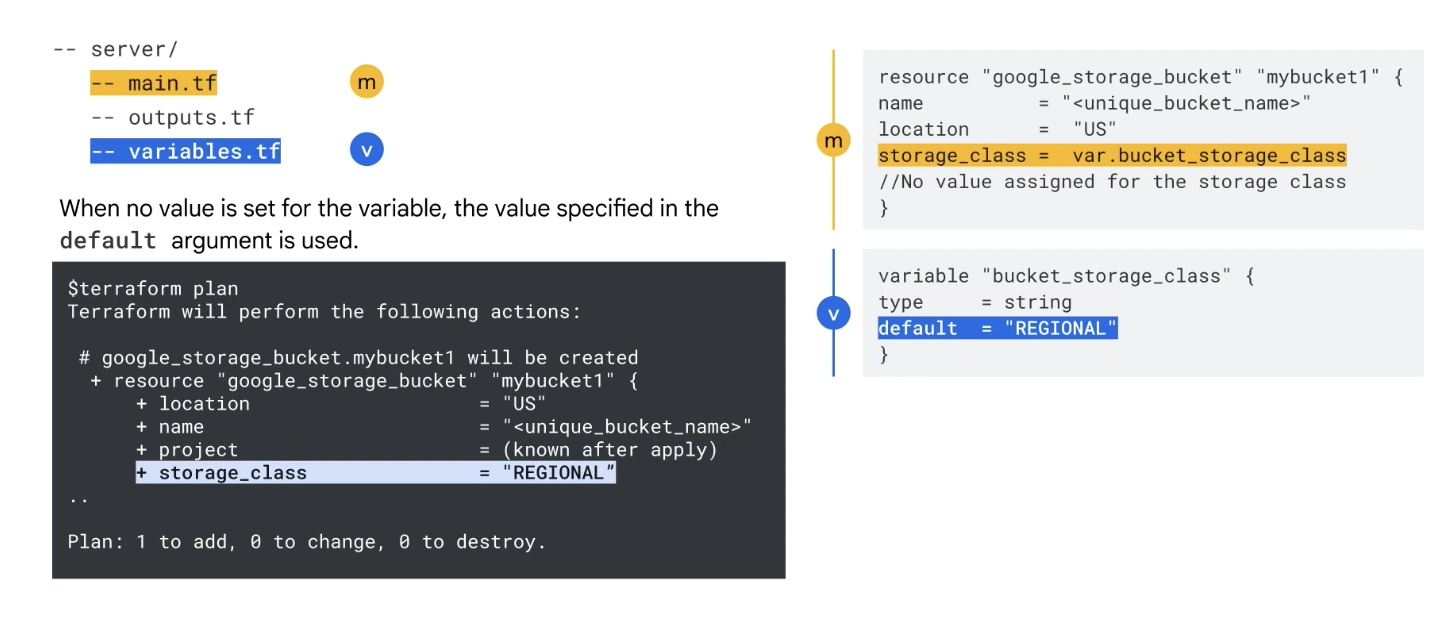

- Variable argument `description` --> it documents the **purpose of the variable**. The description will be displayed at runtime, when no value is assigned for the variable. It should be written from the perspective of the code user (rather than its maintainer)

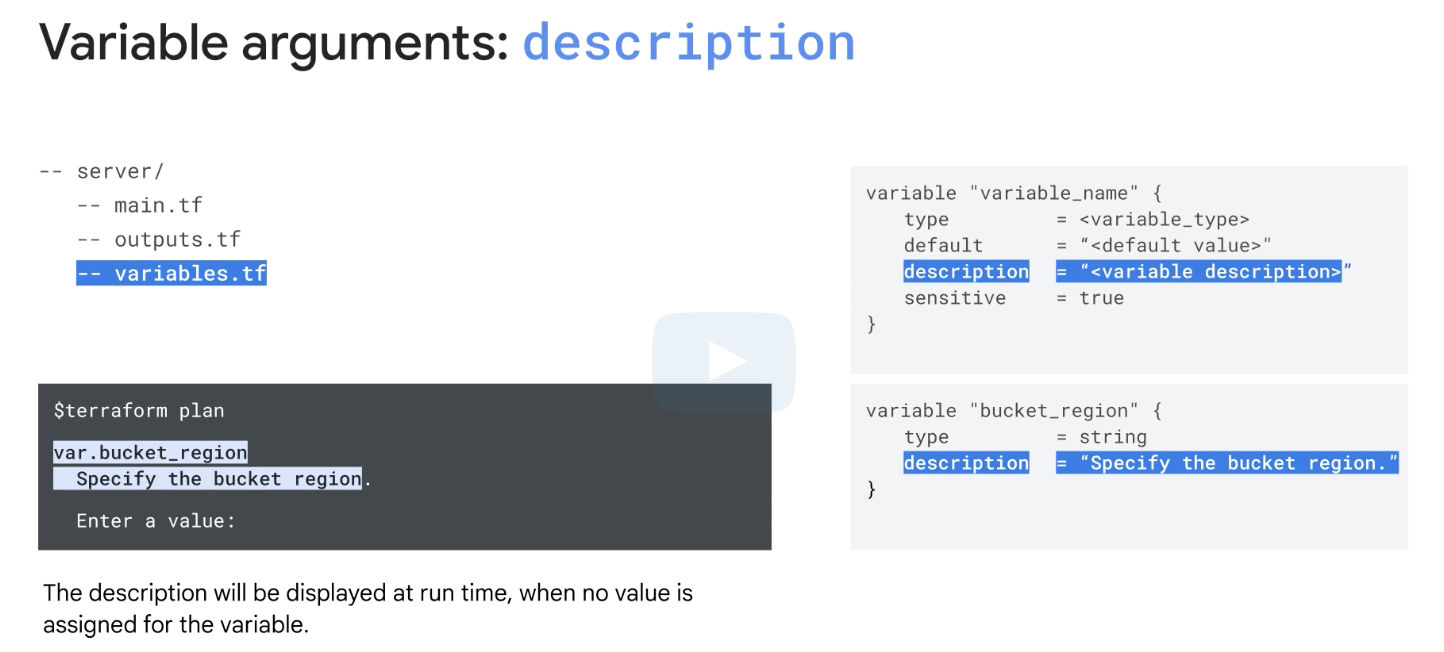

- Variable argument `sensitive` --> it is used to protect sensitive information from being displayed in command outputs and log files. The acceptable value for `sensitive` is `true`, which marks the value as sensitive at runtime in the output of `terraform plan` or `terraform apply`. This parameter is beneficial to use when dealing with sensitive information such as **database credentials** or **API tokens**.

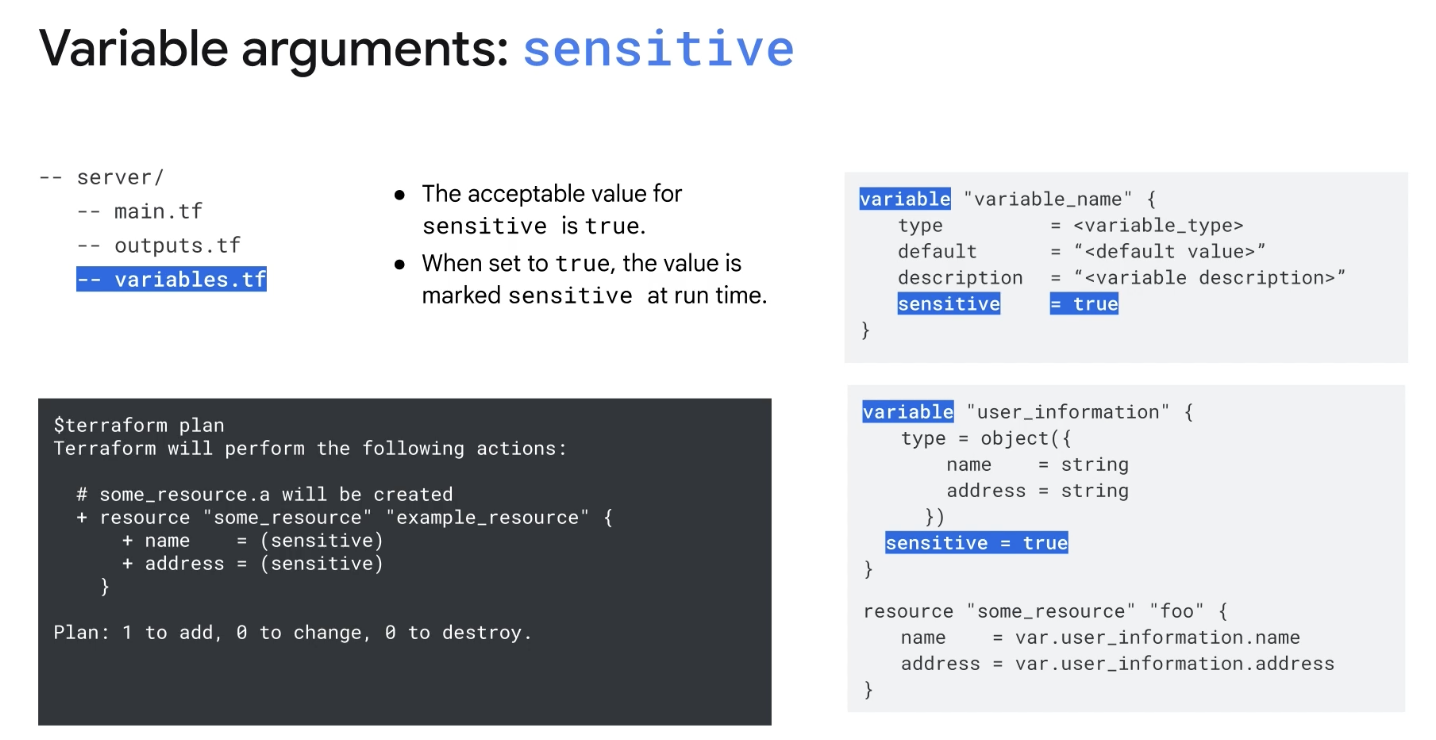

### **Ways to assign values to variables**

1. **`.tfvars` files**: useful for **quickly switching between sets of variables** and **versioning them**

2. **CLI options**: to run quick examples on simple files

3. **Environment variables**: useful in scripts and pipelines

4. **CLI prompt**: if a required variable has not been set via one of the above methods

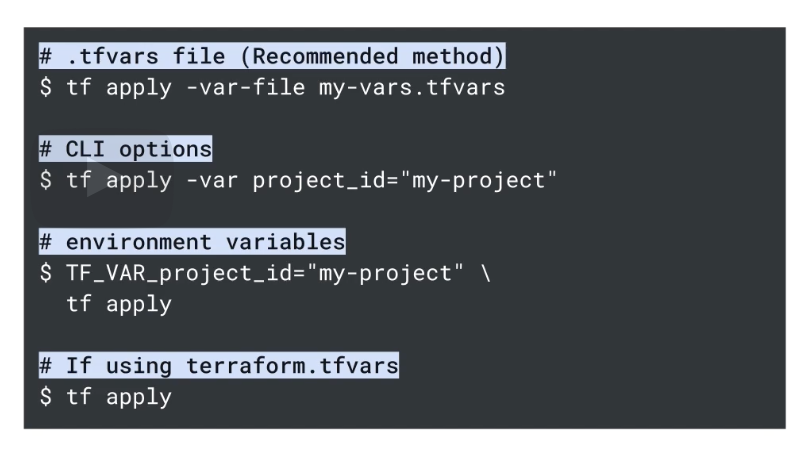

#### **Assign a value to the variable using the `terraform.tfvars` files**

- These **variable definition files** (`terraform.tfvars`) use the **same syntax as HCL**, although they include **only the variable names assignments**

- Terraform **automatically loads** `.tfvars` files as long as they are exactly named `terraform.tfvars` or `terraform.tfvars.json` or `.auto.tfvars` or `.auto.tfvars.json`.

- The variables' definitions provided in these files over-rides those provided in the variables' `default` argument

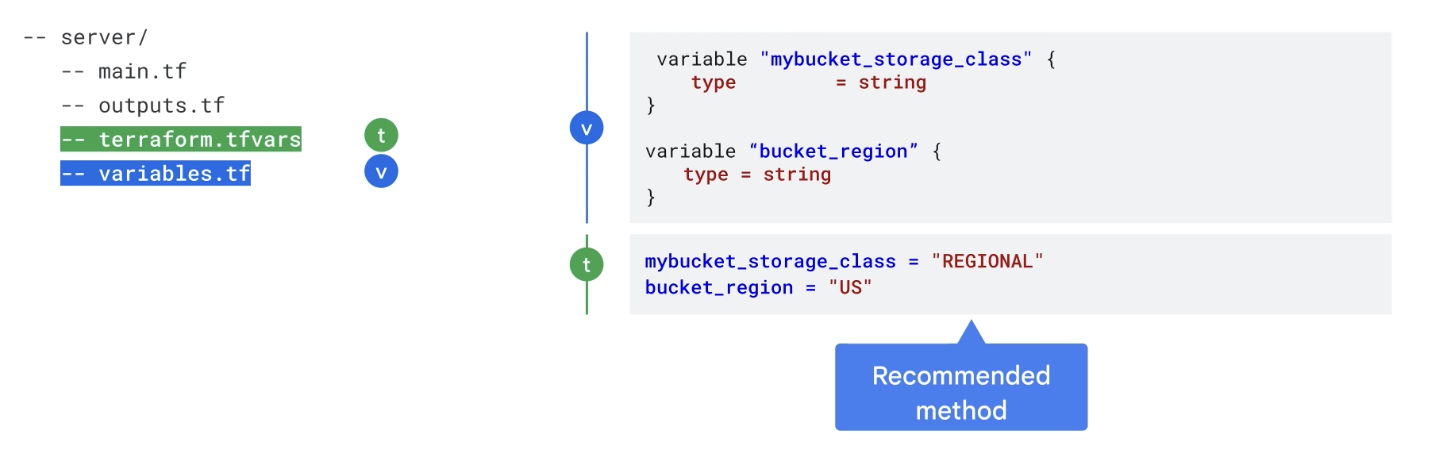

#### **Assign a value to the variable using the `-var` option**

- This is done d**irectly in the CLI** by using the `-var` option, when running either `terraform plan` or `terraform apply`

- This method is frequently used in **automation**, when the `-var` is sourced from **another environment variable**

- This option has the **highest priority** over all other variable assignment methods

#### **Assign a value to the variable at runtime**

- If a variable's value has not been assigned using any method above, **Terraform prompts you to assign a value at runtime via the CLI**

### **Validate variable values by using rules**

- You can v**alidate the value assigned to a variable** using a **validation sub-block** within the **variable block**

- The `validation` sub-block includes a **condition argument** that defines the validation rule

```
variable "mybucket_storageclass" {
  type            = string
  description     = "Set the storage class to the bucket"
  validation {
    condition     = contains(["STANDARD", "MULTI-REGIONAL", "REGIONAL], var.storageclass)
    error_message = "Allowed storage classes are STANDARD, MULTI-REGIONAL and REGIONAL"
  }
}
```

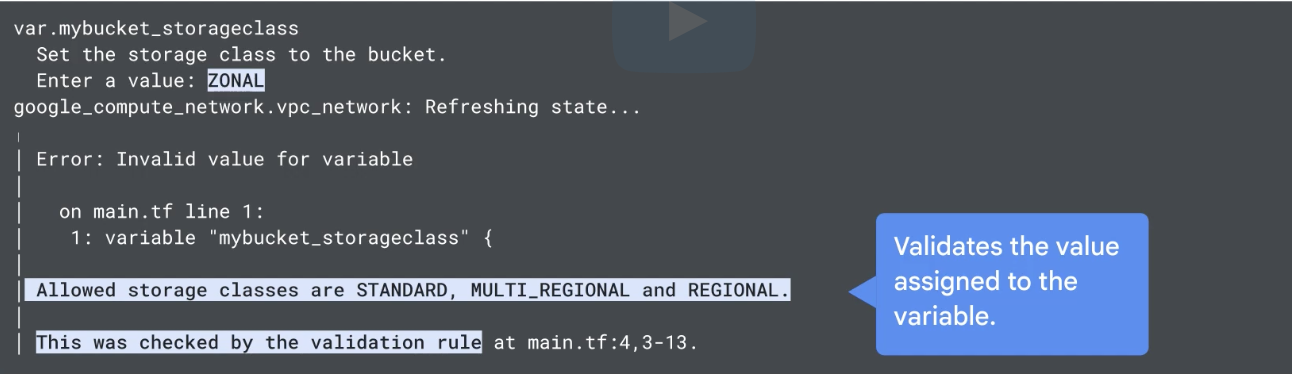

## **3.5: Variables best practices**

### **Parameterise only when necessary**
- Only **parameterise values** that **must vary** for each **instance** or **environment**. Ensure that you have a concrete use case for using a variable

- Changing a variable with a **default value** is **backward-compatible**

- Removing a variable is not backward compatible

### **Provide values in a `.tfvars` file**

- **Command line options** are **ephemeral** in nature and cannot be checked into source control

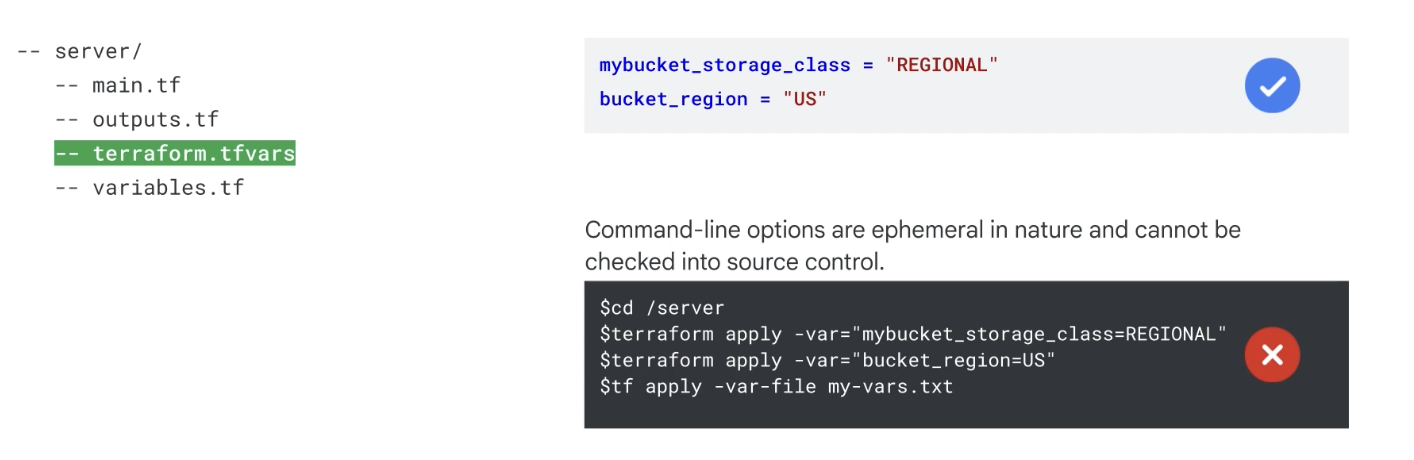

### **Give descriptive names to variables**

- Names representing a **numerical variable** must be **named** with **units**
- Google Cloud APIs don't have standard units, so following this **naming convention clarifies the expected unit** for **configuration maintainers**

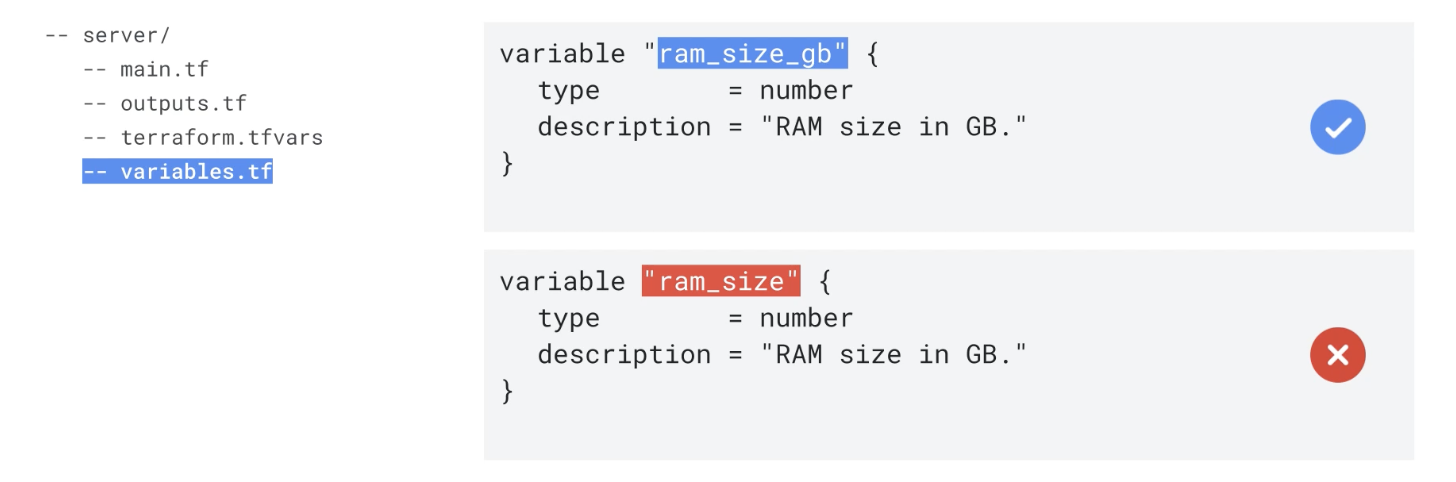

- To **simplify conditional logic**, give **boolean variables positive names**, for example "enable_external_access"

### **Provide meaningful descriptions**

- **Variables' descriptions** are **automatically included in documentation** and **add additional context** for new developers

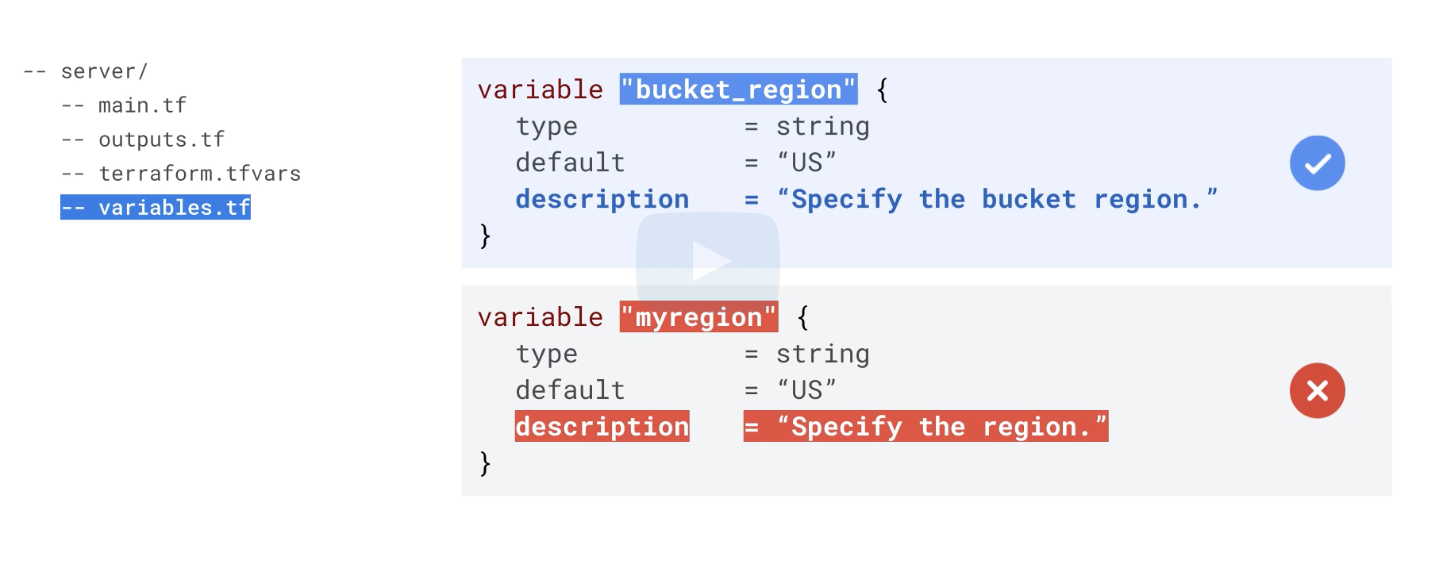

## **3.6: Output Values**

- Output values are similar to **return values** in common programming language
- They **expose information about the resource** to the user of the Terraform configuration. This information is visualised on the CLI

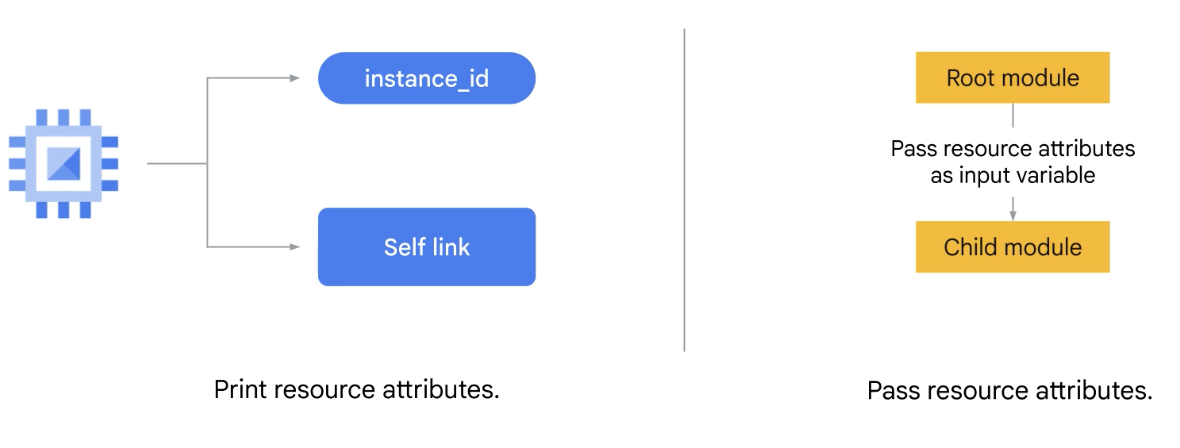

Output values are used for several purposes, including:

- **Print root node resource attributes** in the **CLI** after its deployment

- **Pass information generated by one resource** to another one

### **Print resource attributes by using output values**

- **Output values** are **declared** using the `output` **block**

- You can **declare output values** anywhere within a configuration, but it's recommended best practice to declare them in a **separate file **called `outputs.tf`

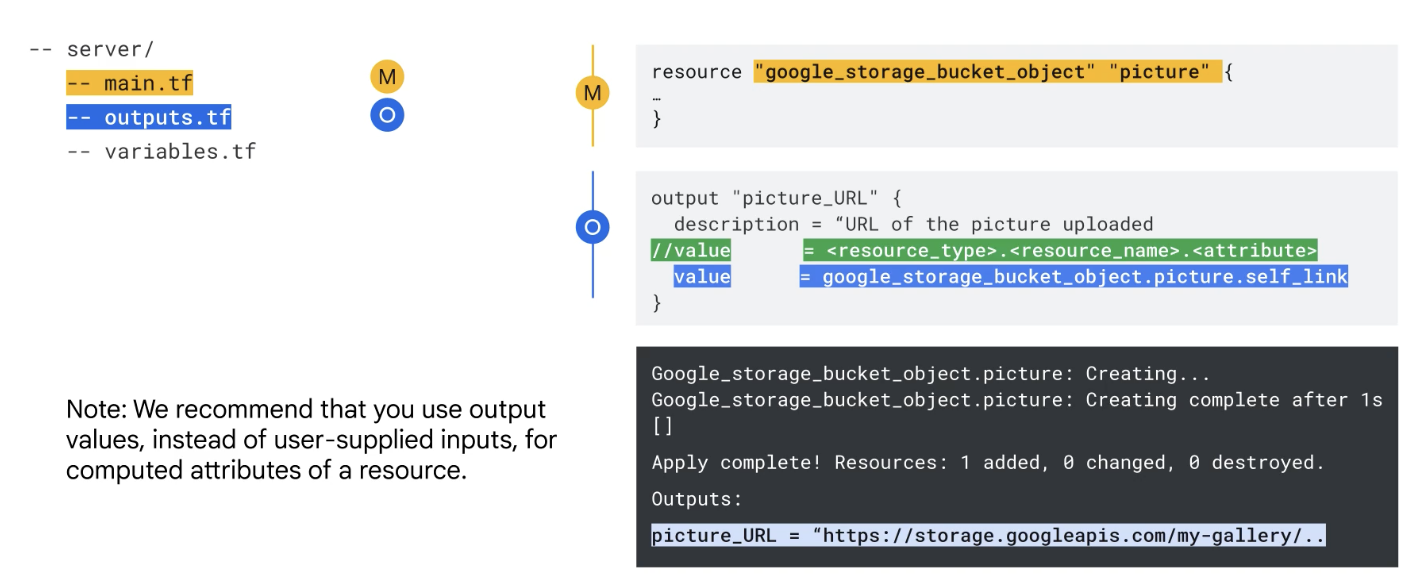

### **Output value arguments**

- `value`: required argument that returns a value to the module's user

- `description`: optional argument that provides an **explanation of the purpose of the output** and **expected value**

- `sensitive`: optionl argument that **masks values** to a resource attribute

### **`terraform output`**

- Command used to **query all the output values** that are part of a project

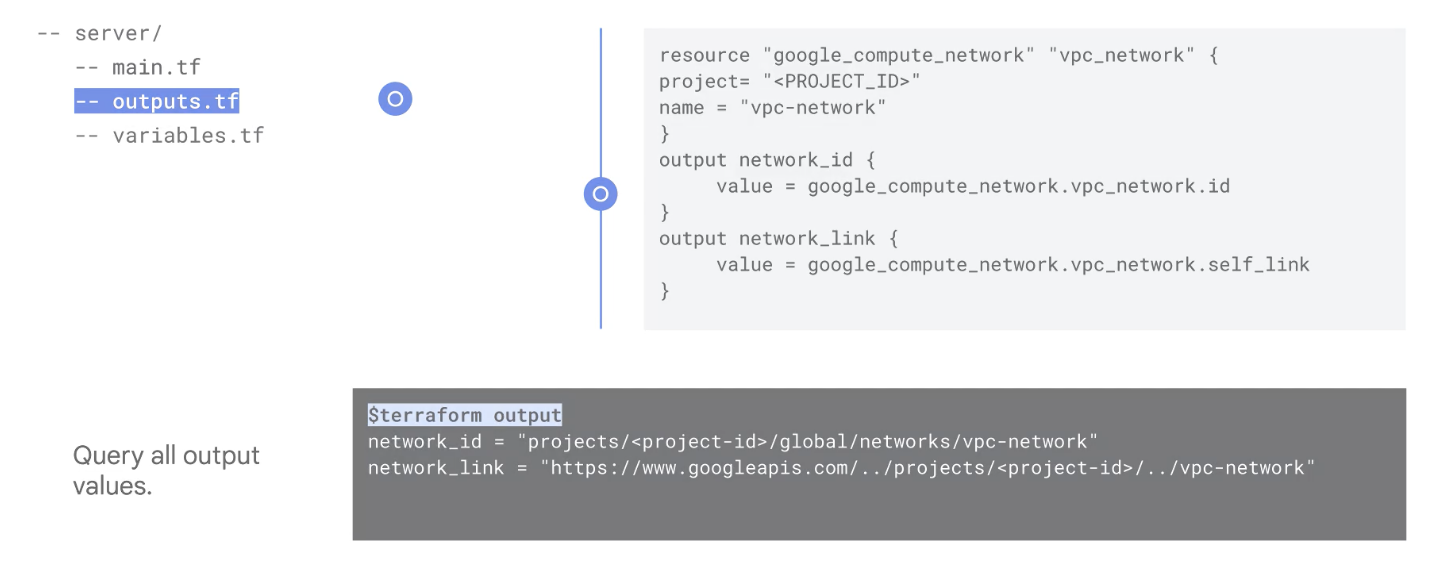

### **Output values best practices**

- **Only output useful information**, i.e. computed information. Avoid output values that simply regurgitate variables or provide known information

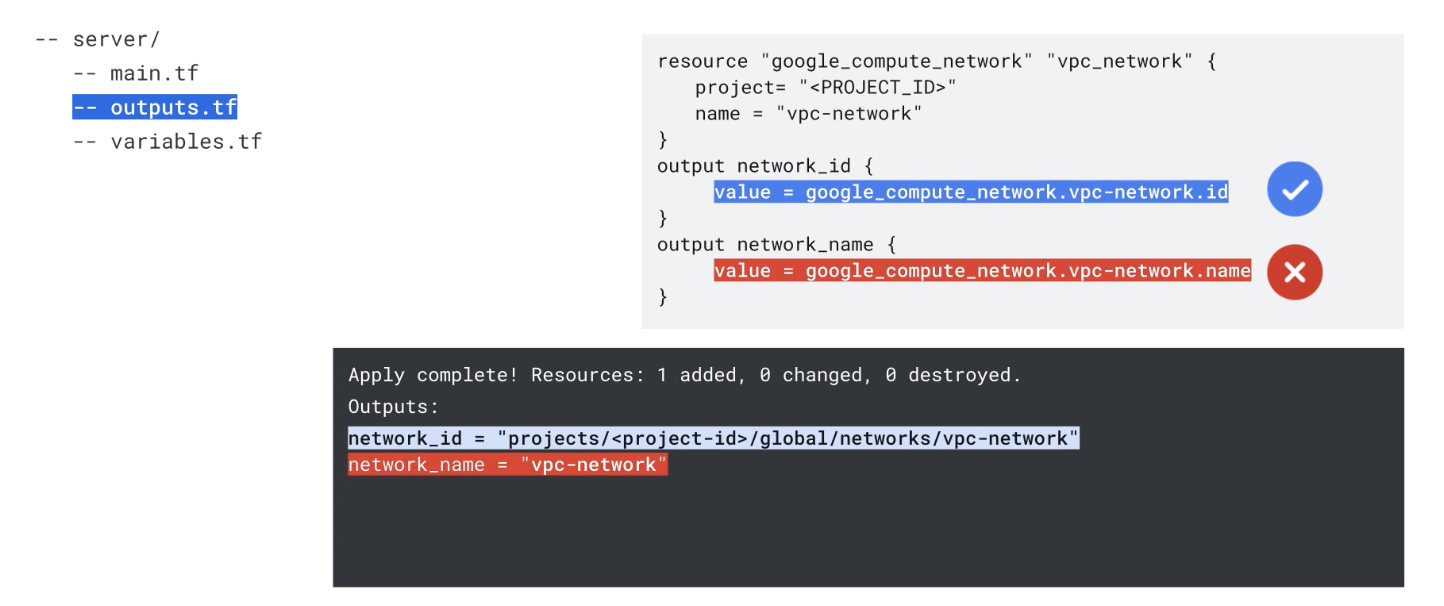

- Provide **meaningful names** and **descriptions**

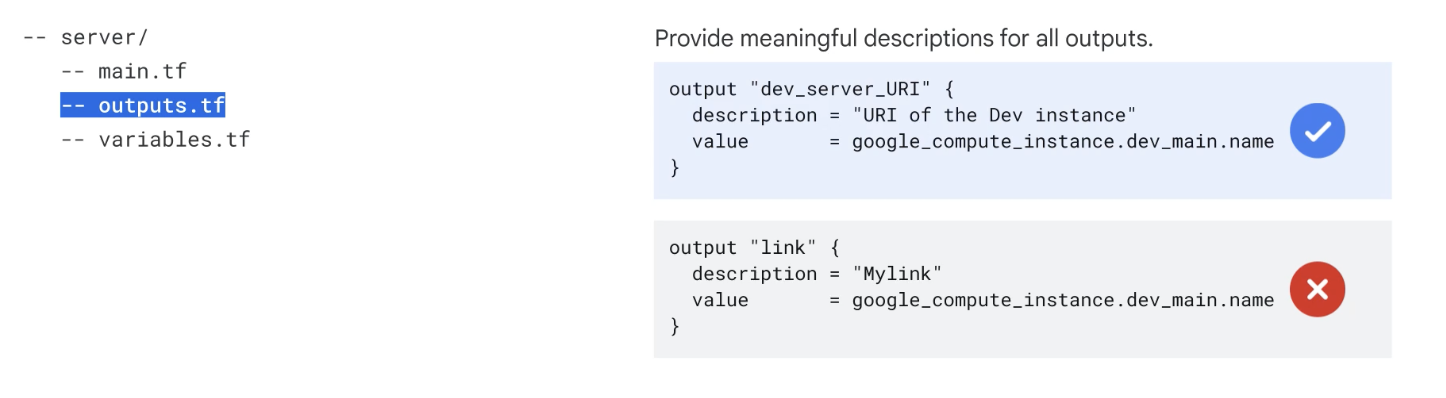

- **Organise all outputs in an `outputs.tf` file**

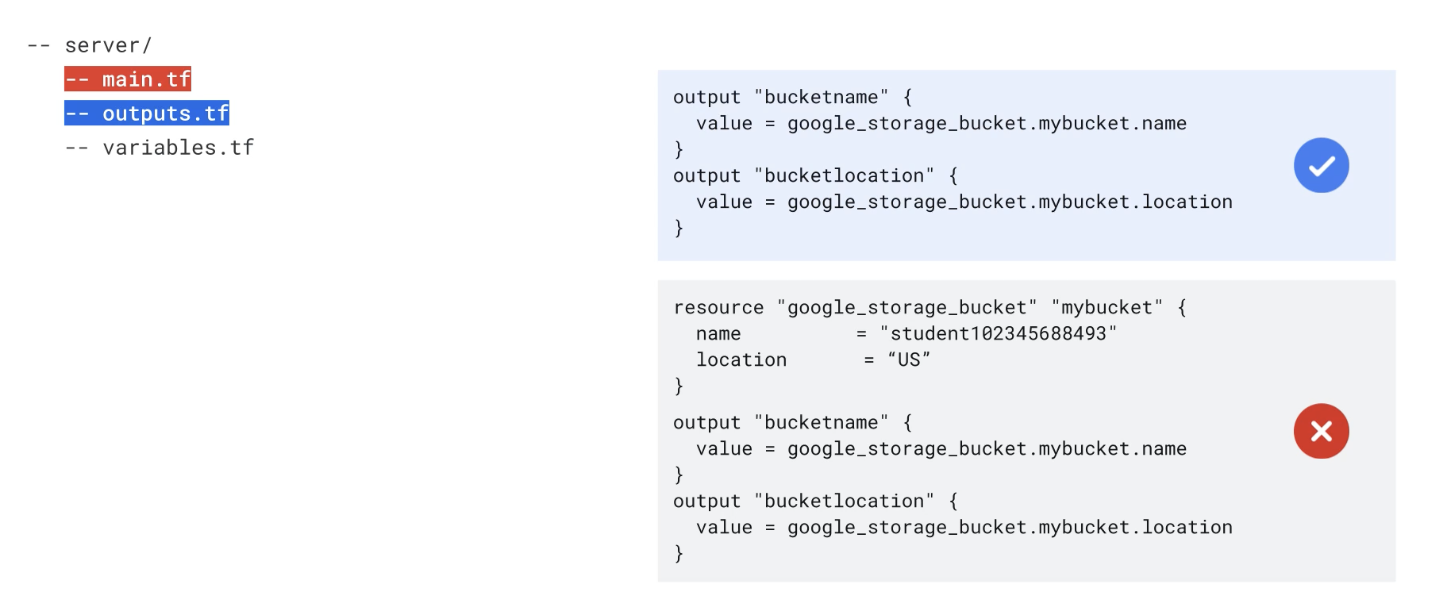

- **Mark sensitive outputs**, rather than attempting to manually encrypt sensitive values, rely on **built-in support for sensitive state management**

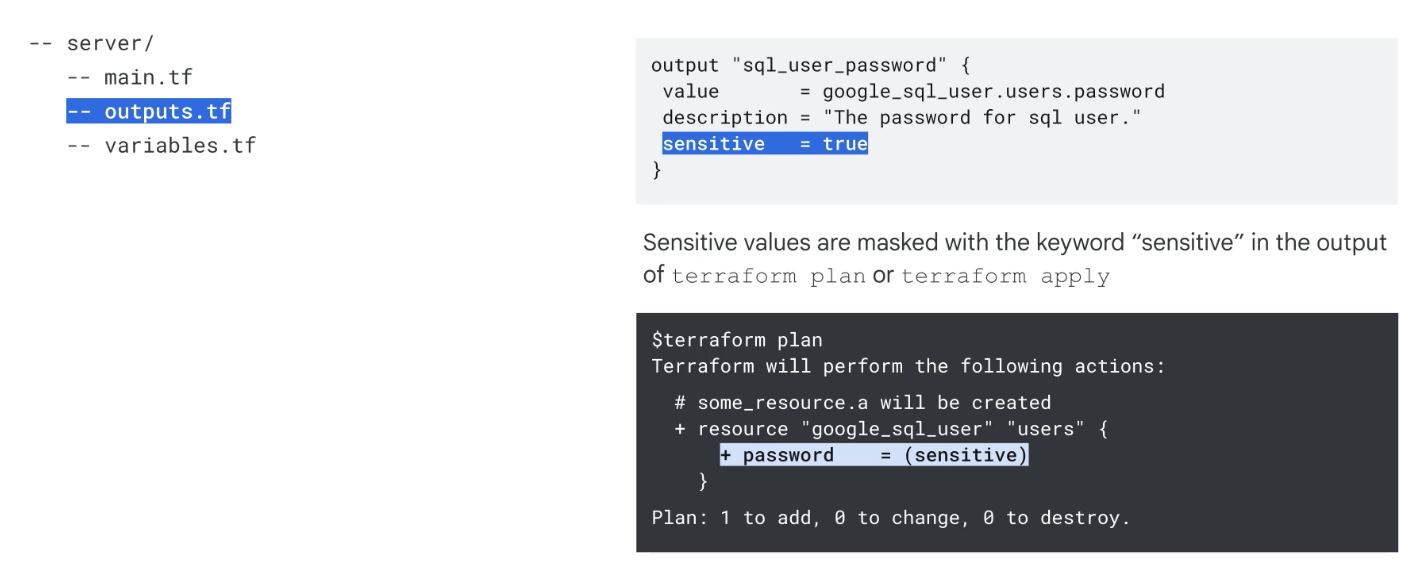

## **3.7: Terraform Registry and the Cloud Foundation Toolkit**


### **The Terraform Registry**

- **Interactive resource** for discovering **providers** and **modules**

- Solutions developed by **HashiCorp**, **third party vendors** and the **Terraform Community**

- https://registry.terraform.io/

- The registry provides **plugins** to **manage infrastructure APIs**, **pre-made modules to quickly configure common infrastructure components** and **examples** on how to write **high quality Terraform code**

### **Cloud Foundation Toolkit (CFT)**

- **CFT** provides a series of **reference modules** for **Terraform** that **reflect Google Cloud best practices**

- https://github.com/GoogleCloudPlatform/cloud-foundation-toolkit

- **CFT modules** can be used without modification to **quickly build a repeatable enterprise-ready foundation** in **Google Cloud**

- CFT modules are also referred to as **Terraform blueprints**

- You can also use **Cloud Foundation Fabric** (**CFF**), a collection of modules and examples for fast protyping or to be modified and used in organisations: https://github.com/GoogleCloudPlatform/cloud-foundation-fabric

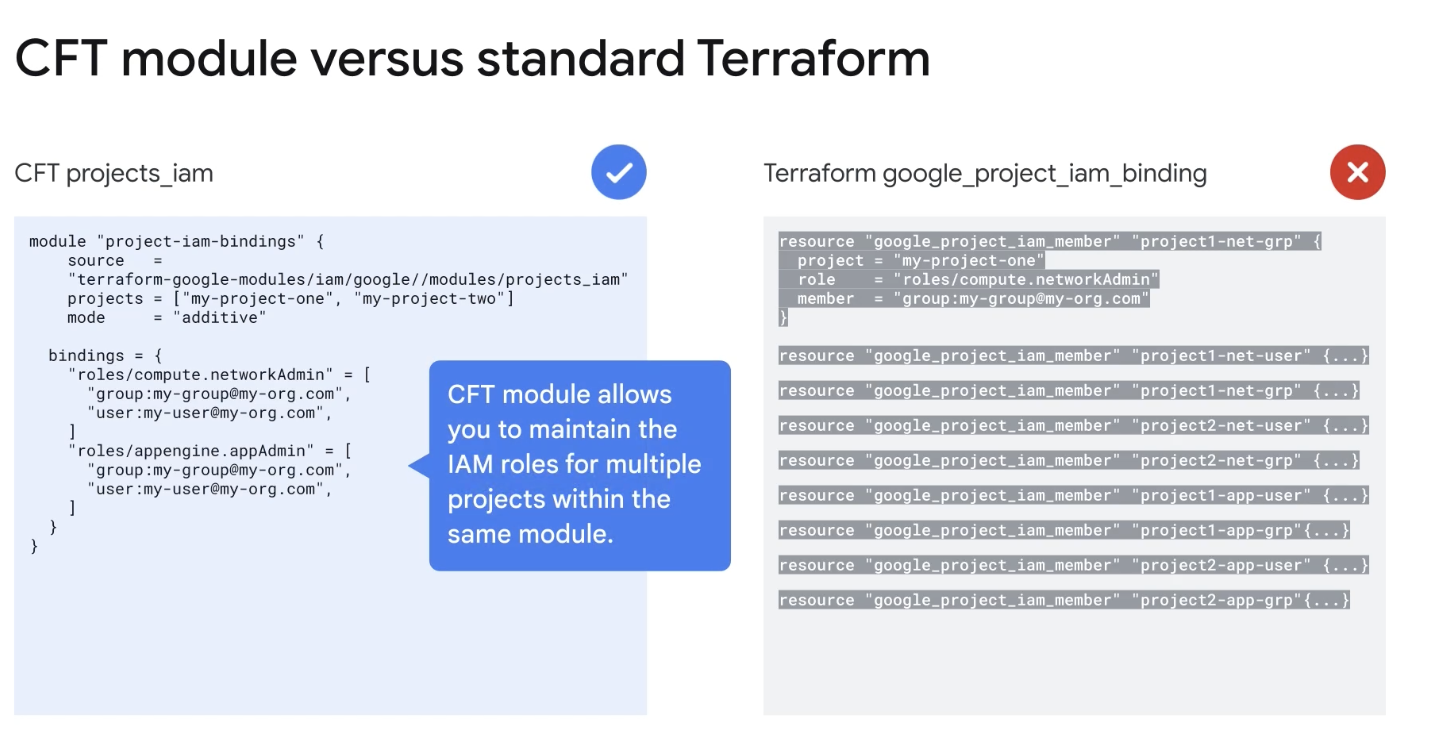

### **Infrastructure Manager (Infra Manager)**

- A managed service that automates the deployment and management of Google Cloud infrastructure resources

- https://cloud.google.com/infrastructure-manager/docs/overview

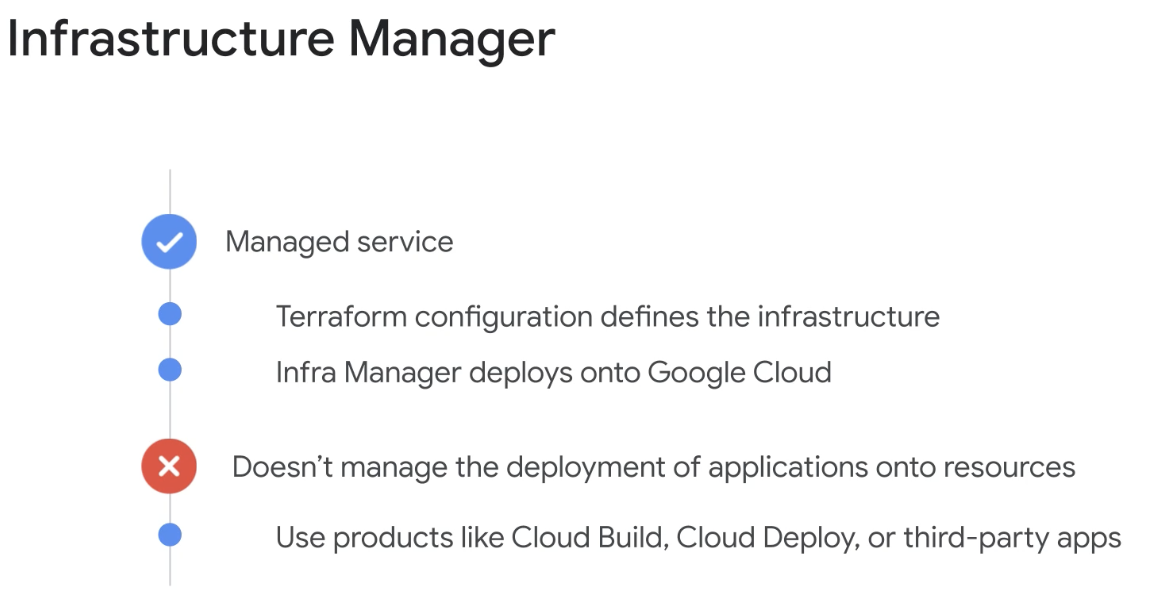